# Convert a PyTorch Model to ONNX and OpenVINO™ IR

This tutorial demonstrates step-by-step instructions on how to do inference on a PyTorch semantic segmentation model, using OpenVINO Runtime.

First, the PyTorch model is converted to [ONNX](https://onnx.ai/) and OpenVINO Intermediate Representation (OpenVINO IR) formats. Then the ONNX and OpenVINO IR models are loaded in OpenVINO Runtime to show model predictions. The model is pre-trained on the [CityScapes](https://www.cityscapes-dataset.com) dataset. The source of the model is [FastSeg](https://github.com/ekzhang/fastseg).

## Preparation

### Imports

In [1]:
import sys
import time
from pathlib import Path

import cv2
import numpy as np
import torch
from IPython.display import Markdown, display
from fastseg import MobileV3Large
from openvino.runtime import Core
!pwd
sys.path.append("utils")
from notebook_utils import CityScapesSegmentation, segmentation_map_to_image, viz_result_image

/home/akashd/projects/project.aice.toolbox-uncertainty/demos_intel_tools/102-pytorch-onnx-to-openvino


### Settings

Set the name for the model, and the width and height of the image that will be used for the network. The CityScapes is pre-trained on images of 2048x1024 resolution. Using smaller dimensions will impact model accuracy, but will improve inference speed. 

In [2]:
IMAGE_WIDTH = 1024  # Suggested values: 2048, 1024 or 512. The minimum width is 512.
# Set IMAGE_HEIGHT manually for custom input sizes. Minimum height is 512.
IMAGE_HEIGHT = 1024 if IMAGE_WIDTH == 2048 else 512
DIRECTORY_NAME = "model"
BASE_MODEL_NAME = DIRECTORY_NAME + f"/fastseg{IMAGE_WIDTH}"

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

### Download the Fastseg Model

Download, load and save the model with pre-trained weights. This may take some time if you have not downloaded the model before.

In [3]:
print("Downloading the Fastseg model (if it has not been downloaded before)....")
model = MobileV3Large.from_pretrained().cpu().eval()
print("Loaded PyTorch Fastseg model")

# Save the model.
model_path.parent.mkdir(exist_ok=True)
torch.save(model.state_dict(), str(model_path))
print(f"Model saved at {model_path}")

Loading pretrained model mobilev3large-lraspp with F=128...


Downloading: "https://github.com/ekzhang/fastseg/releases/download/v0.1-weights/mobilev3large-lraspp-f128-9cbabfde.pt" to /home/akashd/.cache/torch/hub/checkpoints/mobilev3large-lraspp-f128-9cbabfde.pt


  0%|          | 0.00/25.3M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /home/akashd/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


Loaded PyTorch Fastseg model
Model saved at model/fastseg1024.pth


## ONNX Model Conversion

### Convert PyTorch model to ONNX

The output for this cell will show some warnings. These are most likely harmless. When the conversion is successful, the last line of the output will read: `ONNX model exported to fastseg1024.onnx.` 

In [4]:
if not onnx_path.exists():
    dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)

    # For the Fastseg model, setting do_constant_folding to False is required
    # for PyTorch>1.5.1
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        opset_version=11,
        do_constant_folding=False,
    )
    print(f"ONNX model exported to {onnx_path}.")
else:
    print(f"ONNX model {onnx_path} already exists.")

/home/akashd/miniconda3/envs/openvino-env/lib/python3.9/site-packages/geffnet/conv2d_layers.py:39: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)
/home/akashd/miniconda3/envs/openvino-env/lib/python3.9/site-packages/geffnet/conv2d_layers.py:39: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)
/home/akashd/miniconda3/envs/openvino-env/lib/python3.9/site-packages/geffnet/conv2d_layers.py:63: TracerWarning: Converting a tensor to a Pyt

ONNX model exported to model/fastseg1024.onnx.


### Convert ONNX Model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with  `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network.

For more information about Model Optimizer, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

Executing this command may take a while. There may be some errors or warnings in the output. When Model Optimization is successful, the last lines of the output will include: `[ SUCCESS ] Generated IR version 11 model.`

In [5]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --input_shape "[1,3, {IMAGE_HEIGHT}, {IMAGE_WIDTH}]"
                 --mean_values="[123.675, 116.28 , 103.53]"
                 --scale_values="[58.395, 57.12 , 57.375]"
                 --data_type FP16
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "model/fastseg1024.onnx" --input_shape "[1,3, 512, 1024]" --mean_values="[123.675, 116.28 , 103.53]" --scale_values="[58.395, 57.12 , 57.375]" --data_type FP16 --output_dir "model"`

In [6]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/akashd/projects/project.aice.toolbox-uncertainty/demos_intel_tools/102-pytorch-onnx-to-openvino/model/fastseg1024.onnx
	- Path for generated IR: 	/home/akashd/projects/project.aice.toolbox-uncertainty/demos_intel_tools/102-pytorch-onnx-to-openvino/model
	- IR output name: 	fastseg1024
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3, 512, 1024]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[123.675, 116.28 , 103.53]
	- Scale values: 	[58.395, 57.12 , 57.375]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR ge

## Show Results

Confirm that the segmentation results look as expected by comparing model predictions on the ONNX, OpenVINO IR and PyTorch models.

### Load and Preprocess an Input Image

For the OpenVINO IR model, normalization is moved to the model. For the ONNX and PyTorch models, images need to be normalized before propagating through the network. A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided for inference.

In [7]:
def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the given mean and standard deviation
    for CityScapes models.
    """
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

In [8]:
image_filename = "data/street.jpg"
image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)

# Convert the resized images to network input shape.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)

### Load the OpenVINO IR Network and Run Inference on the ONNX model

OpenVINO Runtime can load ONNX models directly. First, load the ONNX model, do inference and show the results. Then, load the model that was converted to OpenVINO Intermediate Representation (OpenVINO IR) with Model Optimizer and do inference on that model, and show the results on an image from [Mapillary Vistas](https://www.mapillary.com/dataset/vistas).

#### 1. ONNX Model in OpenVINO Runtime

In [9]:
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference on the input image.
res_onnx = compiled_model_onnx([normalized_input_image])[output_layer_onnx]

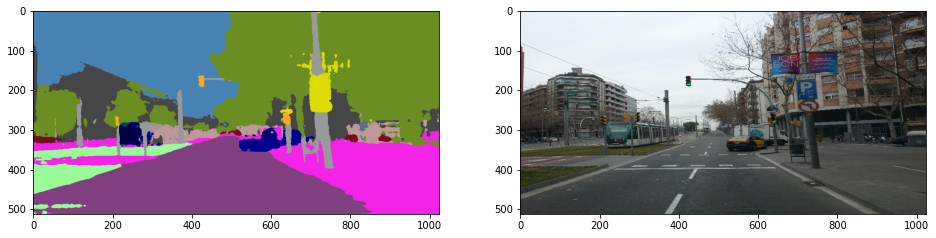

In [10]:
# Convert the network result to a segmentation map and display the result.
result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result_mask_onnx, CityScapesSegmentation.get_colormap()),
    resize=True,
)

#### 2. OpenVINO IR Model in OpenVINO Runtime

In [11]:
# Load the network in OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model=ir_path)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

# Run inference on the input image.
res_ir = compiled_model_ir([input_image])[output_layer_ir]

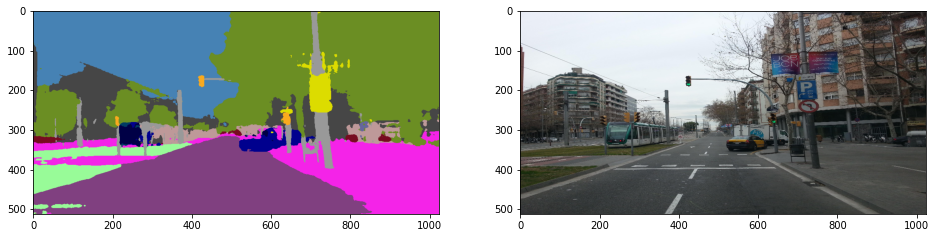

In [12]:
result_mask_ir = np.squeeze(np.argmax(res_ir, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result=result_mask_ir, colormap=CityScapesSegmentation.get_colormap()),
    resize=True,
)

## PyTorch Comparison

Do inference on the PyTorch model to verify that the output visually looks the same as the output on the ONNX/OpenVINO IR models.

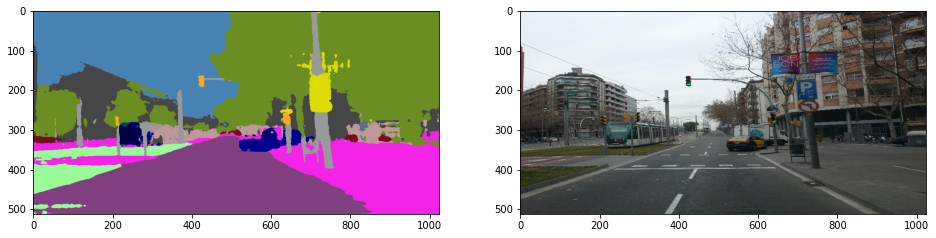

In [13]:
with torch.no_grad():
    result_torch = model(torch.as_tensor(normalized_input_image).float())

result_mask_torch = torch.argmax(result_torch, dim=1).squeeze(0).numpy().astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result=result_mask_torch, colormap=CityScapesSegmentation.get_colormap()),
    resize=True,
)

## Performance Comparison

Measure the time it takes to do inference on twenty images. This gives an indication of performance. For more accurate benchmarking, use the [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html). Keep in mind that many optimizations are possible to improve the performance. 

In [14]:
num_images = 20

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_onnx([normalized_input_image])
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in OpenVINO Runtime/CPU: {time_onnx/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_ir([input_image])
end = time.perf_counter()
time_ir = end - start
print(
    f"OpenVINO IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        model(torch.as_tensor(input_image).float())
    end = time.perf_counter()
    time_torch = end - start
print(
    f"PyTorch model on CPU: {time_torch/num_images:.3f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}"
)



# if "GPU" in ie.available_devices:
#     compiled_model_onnx_gpu = ie.compile_model(model=model_onnx, device_name="GPU")
#     start = time.perf_counter()
#     for _ in range(num_images):
#         compiled_model_onnx_gpu([input_image])
#     end = time.perf_counter()
#     time_onnx_gpu = end - start
#     print(
#         f"ONNX model in OpenVINO/GPU: {time_onnx_gpu/num_images:.3f} "
#         f"seconds per image, FPS: {num_images/time_onnx_gpu:.2f}"
#     )

#     compiled_model_ir_gpu = ie.compile_model(model=model_ir, device_name="GPU")
#     start = time.perf_counter()
#     for _ in range(num_images):
#         compiled_model_ir_gpu([input_image])
#     end = time.perf_counter()
#     time_ir_gpu = end - start
#     print(
#         f"IR model in OpenVINO/GPU: {time_ir_gpu/num_images:.3f} "
#         f"seconds per image, FPS: {num_images/time_ir_gpu:.2f}"
#     )

ONNX model in OpenVINO Runtime/CPU: 0.055 seconds per image, FPS: 18.07
OpenVINO IR model in OpenVINO Runtime/CPU: 0.057 seconds per image, FPS: 17.61
PyTorch model on CPU: 2.115 seconds per image, FPS: 0.47


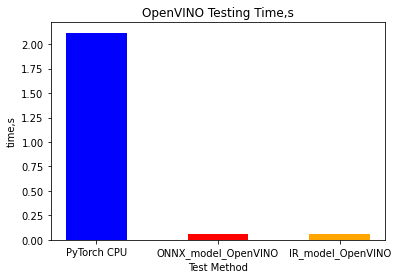

Performance Speedup Testing:  38.23186638161394
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In [18]:
import matplotlib.pyplot as plt

#show performance boost
Pytorch_cpu = time_torch/num_images
ONNX_model = time_onnx/num_images
IR_model = time_ir/num_images

pred_times = [Pytorch_cpu, ONNX_model, IR_model]
tick_label = ['PyTorch CPU', 'ONNX_model_OpenVINO', 'IR_model_OpenVINO']

left = [1,2,3]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red', 'orange'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('OpenVINO Testing Time,s')
plt.show()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup Testing: ",(Pytorch_cpu)/(ONNX_model))

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

**Show Device Information**

In [15]:
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Xeon(R) Gold 6252 CPU @ 2.10GHz


## References

* [Fastseg](https://github.com/ekzhang/fastseg)
* [PIP install openvino-dev](https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md)
* [OpenVINO ONNX support](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_ONNX_Support.html)
* [Model Optimizer Documentation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)
